## 1. EDA

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df_classes = pd.read_csv("/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
df_classes

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown
3,232438397,2
4,230460314,unknown
...,...,...
203764,173077460,unknown
203765,158577750,unknown
203766,158375402,1
203767,158654197,unknown


In [2]:
# 查看类别分布
class_counts = df_classes['class'].value_counts()
class_counts

class
unknown    157205
2           42019
1            4545
Name: count, dtype: int64

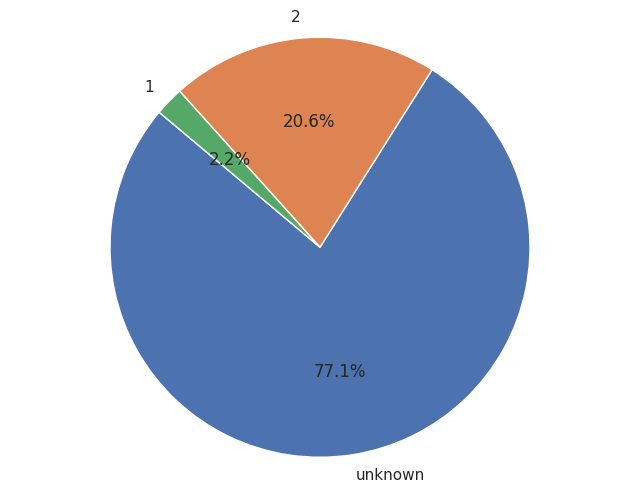

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%',
        startangle=140, colors=sns.color_palette())
plt.axis('equal')
plt.show()

**数据集包含 203769 个节点。其中，2.2%的节点(4545 个)被标记为“非法”(class1)，20.6%(42019个)标记为“合法”(class2)，剩余节点未被明确标注合法性，黑白样本比为10.82%**

In [4]:
df_edges = pd.read_csv("/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
df_edges

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206
...,...,...
234350,158365409,157930723
234351,188708874,188708879
234352,157659064,157659046
234353,87414554,106877725


In [5]:
# 筛选存在标签节点的边
df_classes_tmp = df_classes[(df_classes['class']=='1')|(df_classes['class']=='2')].loc[:,['txId']]
df_edges_filter = pd.merge(df_edges, df_classes_tmp, left_on='txId1', right_on='txId', how='left')
df_edges_filter = pd.merge(df_edges_filter, df_classes_tmp, left_on='txId2', right_on='txId', how='left')
df_edges_filter = df_edges_filter.dropna()
df_edges_filter

,txId1,txId2,txId_x,txId_y
5,232344069,27553029,232344069.0,27553029.0
8,3881097,232457116,3881097.0,232457116.0
15,232051089,232470704,232051089.0,232470704.0
26,230473487,7089694,230473487.0,7089694.0
33,231182296,14660781,231182296.0,14660781.0
...,...,...,...,...
234338,194020062,47521535,194020062.0,47521535.0
234340,158574502,109383451,158574502.0,109383451.0
234344,158594124,157631640,158594124.0,157631640.0
234347,157631640,21644119,157631640.0,21644119.0


**由于模型预测只考虑有标签的交易节点，所以基于有标签的节点筛选其交易流，最终得到36624条交易数据，并基于有标签的节点以及对应的交易边构建交易网络**

In [6]:
import networkx as nx

# 构建区块链交易网络
nodes = list(df_classes_tmp['txId'])
edges = [(a,b) for a,b in zip(df_edges_filter['txId1'], df_edges_filter['txId2'])]
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

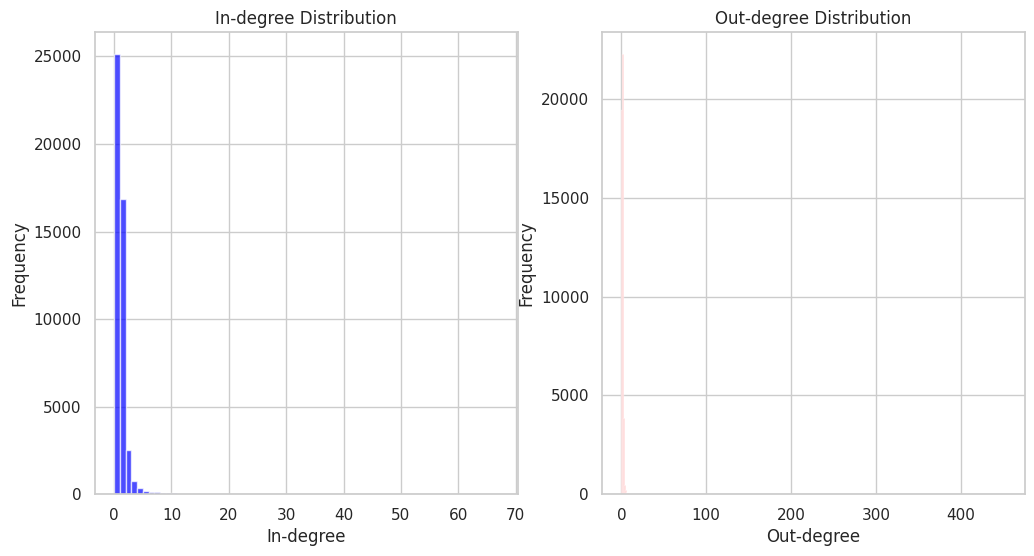

In [7]:
## 绘制度分布图
in_degrees = [G.in_degree(n) for n in G.nodes()]
out_degrees = [G.out_degree(n) for n in G.nodes()]

plt.figure(figsize=(12, 6))

# 入度分布
plt.subplot(1, 2, 1)
plt.hist(in_degrees, bins=range(min(in_degrees), max(in_degrees) + 2), color='blue', alpha=0.7)
plt.title("In-degree Distribution")
plt.xlabel("In-degree")
plt.ylabel("Frequency")

# 出度分布
plt.subplot(1, 2, 2)
plt.hist(out_degrees, bins=range(min(out_degrees), max(out_degrees) + 2), color='red', alpha=0.7)
plt.title("Out-degree Distribution")
plt.xlabel("Out-degree")
plt.ylabel("Frequency")

plt.show()

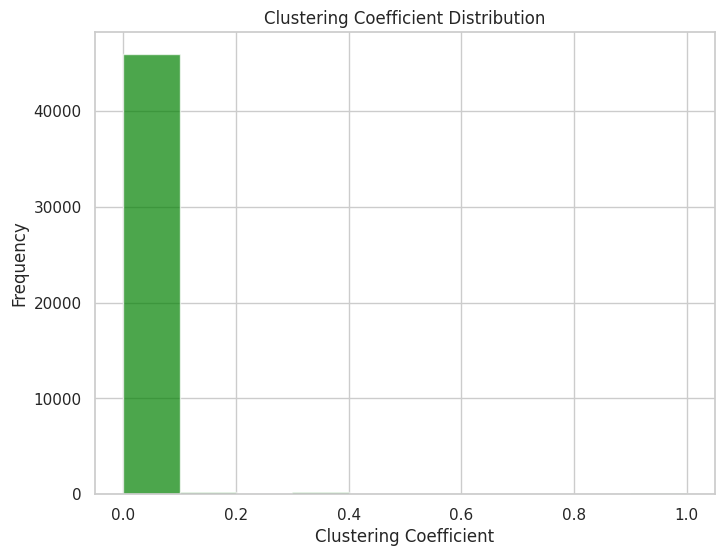

In [8]:
## 绘制局部聚类系数分布图
clustering_coeffs = nx.clustering(G.to_undirected())
coeff_values = list(clustering_coeffs.values())

plt.figure(figsize=(8, 6))
plt.hist(coeff_values, bins=10, color='green', alpha=0.7)
plt.title("Clustering Coefficient Distribution")
plt.xlabel("Clustering Coefficient")
plt.ylabel("Frequency")
plt.show()

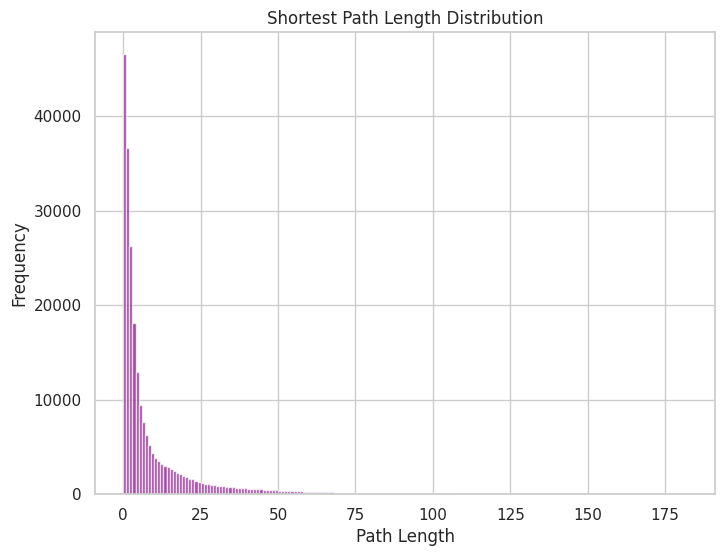

In [9]:
# 绘制最短路径长度分布图
path_lengths = dict(nx.all_pairs_shortest_path_length(G))

# 提取所有路径长度
all_lengths = []
for node in path_lengths:
    lengths = list(path_lengths[node].values())
    all_lengths.extend(lengths)

plt.figure(figsize=(8, 6))
plt.hist(all_lengths, bins=range(max(all_lengths)+1), color='purple', alpha=0.7)
plt.title("Shortest Path Length Distribution")
plt.xlabel("Path Length")
plt.ylabel("Frequency")
plt.show()

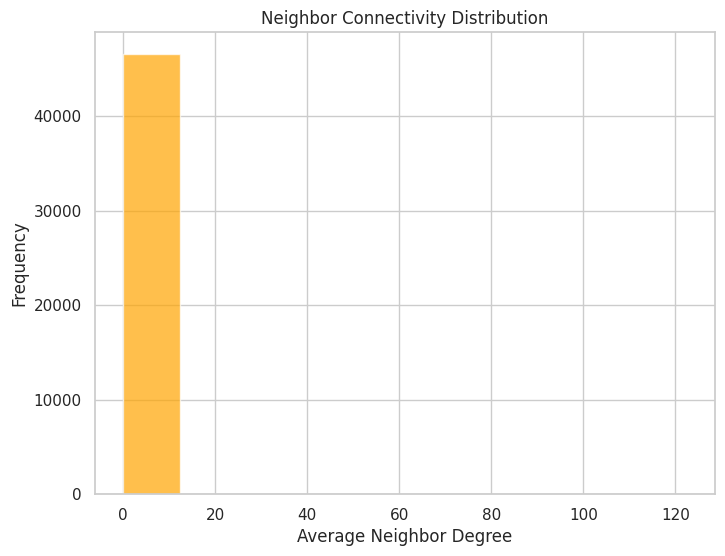

In [10]:
## 邻居关系图
neighbor_connectivity = nx.average_neighbor_degree(G)
neighbor_values = list(neighbor_connectivity.values())

plt.figure(figsize=(8, 6))
plt.hist(neighbor_values, bins=10, color='orange', alpha=0.7)
plt.title("Neighbor Connectivity Distribution")
plt.xlabel("Average Neighbor Degree")
plt.ylabel("Frequency")
plt.show()

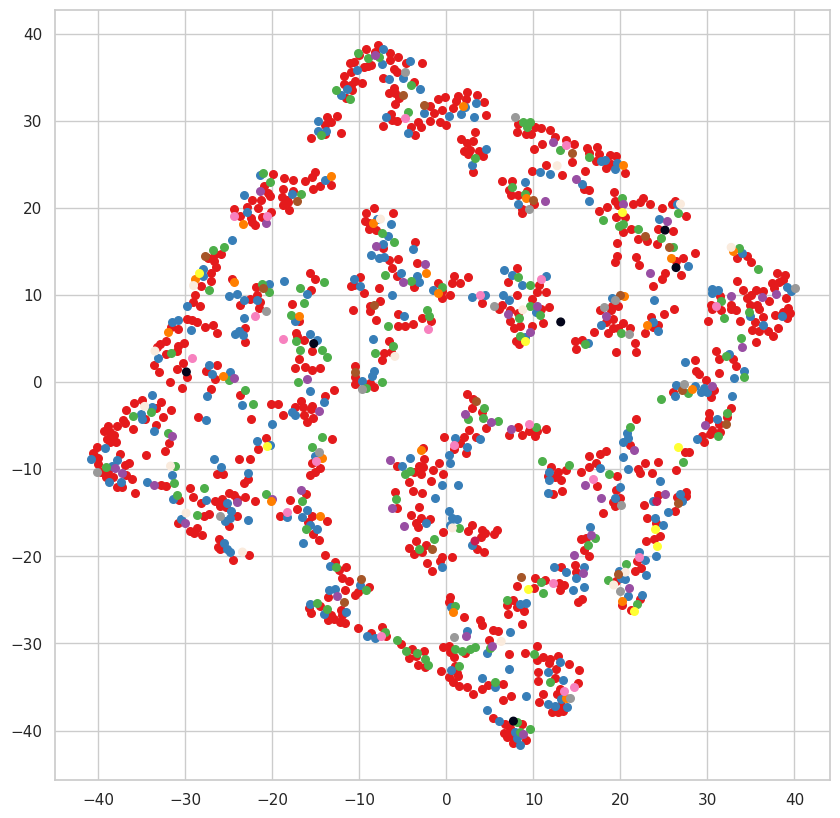

In [11]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from networkx.algorithms.community import greedy_modularity_communities
import numpy as np

# 检测社区
largest_cc = max(nx.connected_components(G.to_undirected()), key=len)
G_sub = G.subgraph(largest_cc)
communities = list(greedy_modularity_communities(G_sub))
community_dict = {node: index for index, community in enumerate(communities) for node in community}
node_positions = nx.random_layout(G_sub)
node_positions = np.array([node_positions[node] for node in G_sub.nodes()])
node_tsne = TSNE(n_components=2, random_state=0).fit_transform(node_positions)
plt.figure(figsize=(10, 10))
for i, community in enumerate(communities):
    nodes_in_community = [node for node in community]
    x = [node_tsne[list(G_sub.nodes()).index(node)][0] for node in nodes_in_community]
    y = [node_tsne[list(G_sub.nodes()).index(node)][1] for node in nodes_in_community]
    
    plt.scatter(x, y, c=plt.cm.Set1(i / len(communities)), label=f"Community {i+1}", s=30)
plt.show()

In [12]:
## 节点特征分析
df_fet = pd.read_csv('/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_features.csv',header=None)
df_fet

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203764,173077460,49,-0.145771,-0.163752,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,-0.135803,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
203765,158577750,49,-0.165920,-0.123607,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.156418,...,0.162722,0.010822,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,-1.760926,-1.760984
203766,158375402,49,-0.172014,-0.078182,1.018602,0.028105,-0.043875,0.054722,-0.061584,-0.163626,...,1.261246,1.985050,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
203767,158654197,49,-0.172842,-0.176622,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.163501,...,-0.397749,-0.411776,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399


In [13]:
# 筛选存在标签的特征数据
df_fet_sub = df_fet[(df_classes['class']=='1')|(df_classes['class']=='2')]
df_fet_sub.columns = [str(i) for i in range(len(df_fet_sub.columns))]
df_fet_sub.head()

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
9,232029206,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792
10,232344069,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
11,27553029,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.141519,...,-0.539735,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
16,3881097,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,-0.163640,...,-0.577099,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984


In [14]:
df_fet_lab = pd.merge(df_fet_sub, df_classes, left_on='0', right_on='txId')
df_fet_lab.drop(['txId'], axis=1, inplace=True)
df_fet_lab

,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,class
0,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,2
1,232029206,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,...,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792,2
2,232344069,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,...,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,2
3,27553029,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.141519,...,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,2
4,3881097,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,-0.163640,...,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46559,80329479,49,-0.159293,-0.037276,1.018602,-0.121970,0.035526,-0.113002,-0.061584,-0.149635,...,1.408971,0.231244,-0.388216,-0.098889,1.931078,3.168259,3.707301,-1.390548,-1.214035,2
46560,158406298,49,-0.172962,-0.126566,1.018602,-0.121970,-0.063725,-0.113002,-0.061584,-0.163622,...,0.647874,0.241128,0.241406,10.914916,1.700384,-0.131155,7.914145,-0.120613,-0.119792,2
46561,158375075,49,-0.170412,-0.078164,1.018602,0.028105,-0.043875,0.054722,-0.061584,-0.163631,...,1.606604,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,1
46562,147478192,49,-0.093732,-0.116160,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.082559,...,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,2


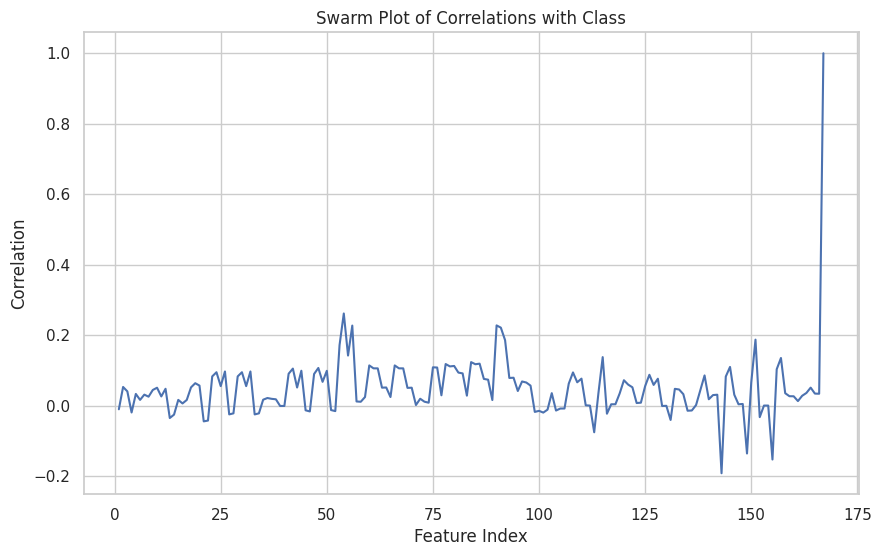

In [15]:
corr_class = df_fet_lab.drop(['0'], axis=1).corr()['class']
corr_class_df = corr_class.reset_index()
corr_class_df['Feature'] = range(1, len(corr_class_df) + 1)
corr_class_df.columns = ['index', 'Correlation', 'Feature']
plt.figure(figsize=(10, 6))
sns.lineplot(x="Feature", y="Correlation", data=corr_class_df)
plt.title('Swarm Plot of Correlations with Class')
plt.xlabel('Feature Index')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()

## 2. Model Data Pre

In [16]:
!pip install torch_geometric

In [17]:
## 加载模型数据
classes_df = pd.read_csv('/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_classes.csv')
edges_df = pd.read_csv('/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv')
features_df = pd.read_csv('/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_features.csv', header=None)
## 处理节点标签
classes_df = classes_df[classes_df['class'] != 'unknown']
node_labels = classes_df.set_index('txId')['class'].apply(lambda x: 0 if x == '1' else 1).to_dict()
## 处理节点特征
features_df = features_df.set_index(0)
node_features = features_df.loc[list(node_labels.keys())].values
# 筛选出有效的边（两端的节点都在node_labels中）
edges = edges_df[(edges_df['txId1'].isin(node_labels)) & (edges_df['txId2'].isin(node_labels))]
len(node_labels), len(edges)

(46564, 36624)

In [18]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_undirected
from torch_geometric.utils import from_scipy_sparse_matrix
from scipy.sparse import coo_matrix

# 获取节点列表并重新编号
all_nodes = np.array(list(node_labels.keys()))
node_mapping = {node: i for i, node in enumerate(all_nodes)}
num_nodes = len(all_nodes)

# 将原始的节点ID映射到重新编号后的节点ID
edges_mapped = edges.applymap(lambda x: node_mapping[x]).values.T
edge_index = torch.tensor(edges_mapped, dtype=torch.long)

In [19]:
## 构建数据x, y, edge_index
x = torch.tensor(node_features, dtype=torch.float)
y = torch.tensor([node_labels[txId] for txId in all_nodes], dtype=torch.long)
edge_index, _ = from_scipy_sparse_matrix(coo_matrix((torch.ones(edge_index.shape[1]), 
                                                     edge_index), 
                                                     shape=(num_nodes, num_nodes)))
x.size(), y.size(), edge_index.size()

(torch.Size([46564, 166]), torch.Size([46564]), torch.Size([2, 36624]))

In [20]:
## 创建PyTorch Geometric数据对象, 并按照8:2随机划分训练测试集
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

data = Data(x=x, edge_index=edge_index, y=y)
train_mask = torch.rand(num_nodes) < 0.8
test_mask = ~train_mask
data.train_mask = train_mask
data.test_mask = test_mask

## 3. GCN

In [21]:
## 定义模型结构
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.gc1 = GCNConv(num_node_features, hidden_channels)
        self.gc2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.gc1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.gc2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [22]:
# 初始化模型
model = GCN(num_node_features=x.shape[1], hidden_channels=64, num_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model

GCN(
  (gc1): GCNConv(166, 64)
  (gc2): GCNConv(64, 2)
)

In [23]:
## 模型训练
loss_st = list()
accs_train = list()
accs_test = list()
for epoch in range(1, 201):
    ## 训练模型
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    loss_st.append(loss.detach().numpy())
    
    ## 模型验证
    ### 训练集验证
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()
    acc_train = int(correct) / int(data.train_mask.sum())
    accs_train.append(acc_train)
    
    ### 测试集验证
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc_test = int(correct) / int(data.test_mask.sum())
    accs_test.append(acc_test)
    if epoch % 10 == 0:
        print(f"""====================== Epoch {epoch} ======================
Loss: {loss:.4f}, Train Accuracy: {acc_train:.4f}, Test Accuracy: {acc_test:.4f}""")

====================== Epoch 10 ======================
Loss: 0.5016, Train Accuracy: 0.9222, Test Accuracy: 0.9214
====================== Epoch 20 ======================
Loss: 0.2788, Train Accuracy: 0.9418, Test Accuracy: 0.9358
====================== Epoch 30 ======================
Loss: 0.2072, Train Accuracy: 0.9501, Test Accuracy: 0.9516
====================== Epoch 40 ======================
Loss: 0.1804, Train Accuracy: 0.9509, Test Accuracy: 0.9536
====================== Epoch 50 ======================
Loss: 0.1708, Train Accuracy: 0.9585, Test Accuracy: 0.9597
====================== Epoch 60 ======================
Loss: 0.1581, Train Accuracy: 0.9605, Test Accuracy: 0.9600
====================== Epoch 70 ======================
Loss: 0.1514, Train Accuracy: 0.9628, Test Accuracy: 0.9621
====================== Epoch 80 ======================
Loss: 0.1474, Train Accuracy: 0.9640, Test Accuracy: 0.9636
====================== Epoch 90 ======================
Loss: 0.1424, Train Accur

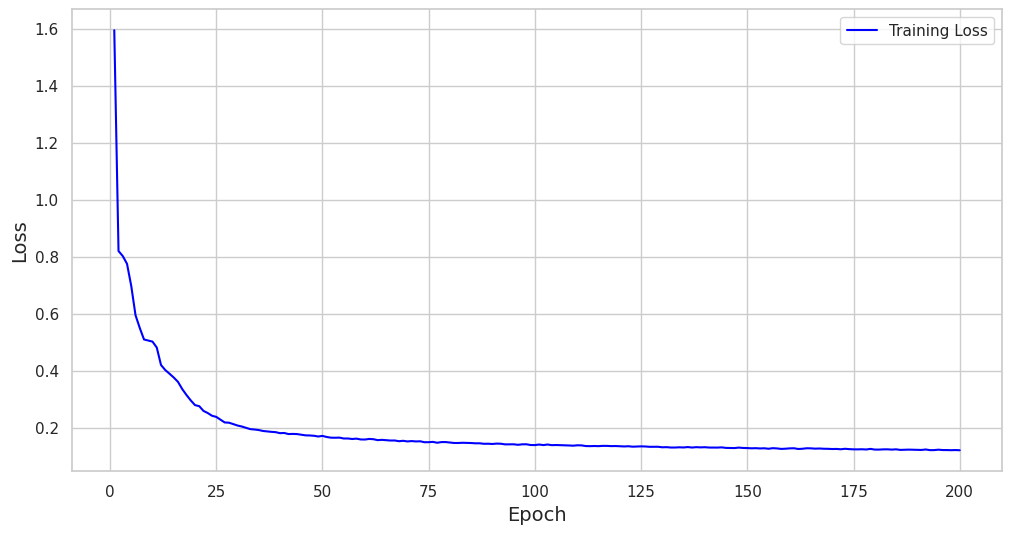

In [24]:
# 绘制损失变化图
plt.figure(figsize=(12, 6))
plt.plot(range(1, 201), loss_st, color='blue', label='Training Loss')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

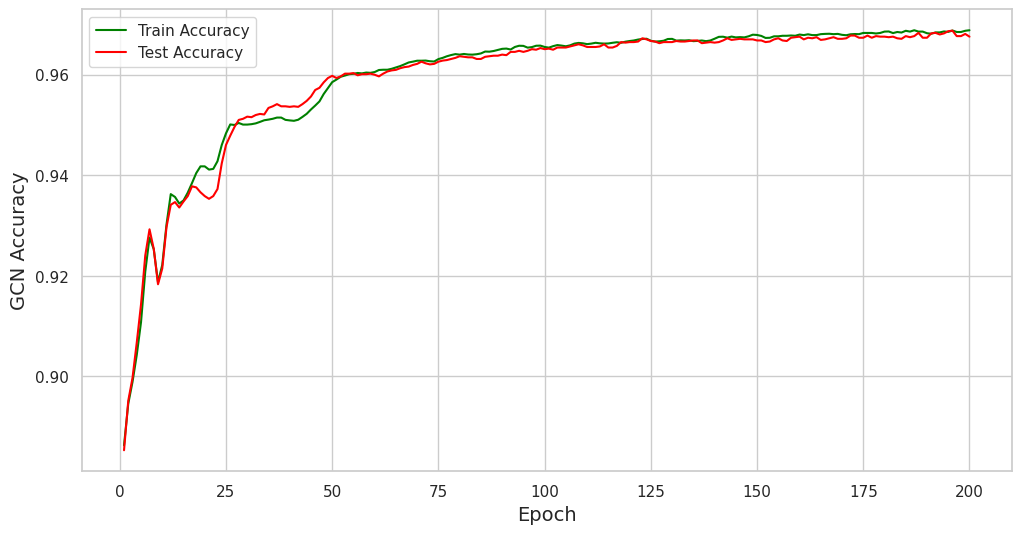

In [25]:
# 绘制训练和测试准确率变化图
plt.figure(figsize=(12, 6))
plt.plot(range(1, 201), accs_train, color='green', label='Train Accuracy')
plt.plot(range(1, 201), accs_test, color='red', label='Test Accuracy')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('GCN Accuracy', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

### GCN Model Eval

In [26]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import numpy as np

# 在测试集和训练集上评估模型
print("=== GCN Model Eval ===")
model.eval()
with torch.no_grad():
    out = model(data)
    pred = out.argmax(dim=1)
    
    # 训练集评估
    y_train = data.y[data.train_mask].cpu().numpy()
    y_pred_train = pred[data.train_mask].cpu().numpy()
    
    acc_train = accuracy_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train, average='macro')
    f1_train = f1_score(y_train, y_pred_train, average='macro')
    
    print(f"Train Accuracy: {acc_train:.4f}")
    print(f"Train Recall: {recall_train:.4f}")
    print(f"Train F1 Score: {f1_train:.4f}")
    
    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_accuracy_train = cm_train.astype('float') / cm_train.sum(axis=1)[:, np.newaxis]
    
    # 测试集评估
    y_test = data.y[data.test_mask].cpu().numpy()
    y_pred_test = pred[data.test_mask].cpu().numpy()
    
    acc = accuracy_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test, average='macro')
    f1 = f1_score(y_test, y_pred_test, average='macro')
    
    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    
    cm = confusion_matrix(y_test, y_pred_test)
    cm_accuracy = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

=== GCN Model Eval ===
Train Accuracy: 0.9688
Train Recall: 0.8670
Train F1 Score: 0.9028
Test Accuracy: 0.9675
Test Recall: 0.8728
Test F1 Score: 0.9006


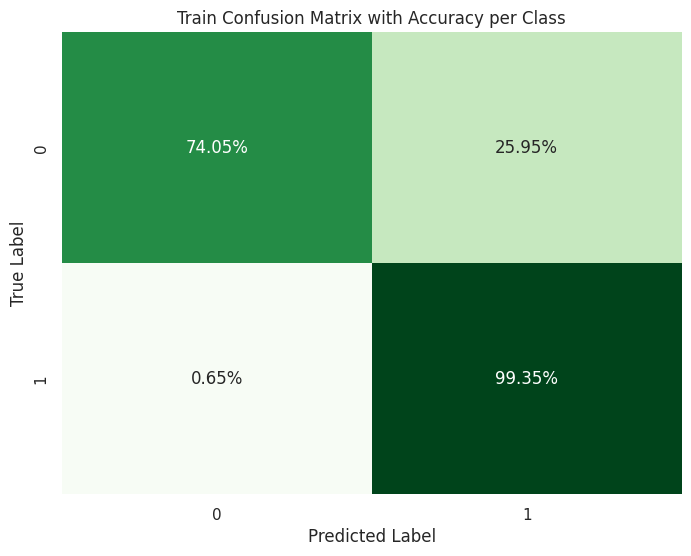

In [27]:
# 绘制训练集混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm_accuracy_train, annot=True, fmt='.2%', cmap='Greens', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Train Confusion Matrix with Accuracy per Class')
plt.show()

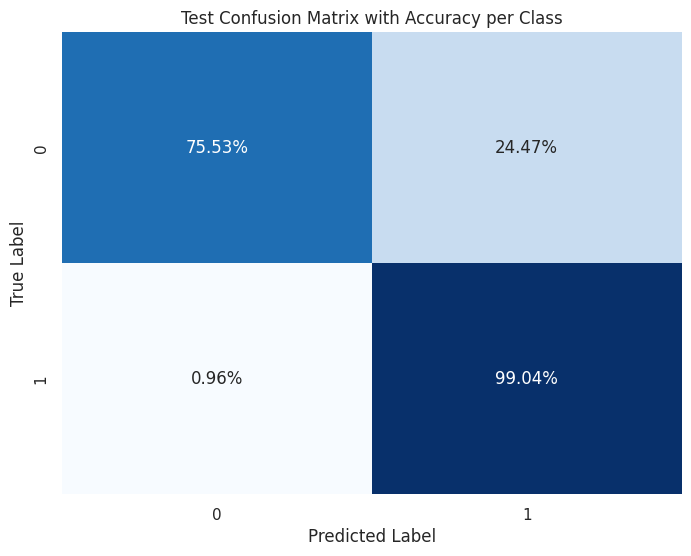

In [28]:
# 绘制测试集混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm_accuracy, annot=True, fmt='.2%', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Test Confusion Matrix with Accuracy per Class')
plt.show()

## 4. GCN-LSTM

In [29]:
from torch.nn import LSTM

## 定义GCN-LSTM模型
class GCN_LSTM(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes, lstm_hidden_size, lstm_num_layers):
        super(GCN_LSTM, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.lstm = LSTM(hidden_channels, lstm_hidden_size, lstm_num_layers, batch_first=True)
        self.fc = torch.nn.Linear(lstm_hidden_size, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # GCN部分
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        # LSTM部分
        x = x.unsqueeze(0)  # 增加一个batch维度，因为LSTM需要3维输入(batch, seq, feature)
        x, _ = self.lstm(x)
        x = x.squeeze(0)  # 去除batch维度

        # 全连接层输出分类结果
        x = self.fc(x)

        return F.log_softmax(x, dim=1)

In [30]:
# 初始化模型
model = GCN_LSTM(num_node_features=x.shape[1], hidden_channels=64, num_classes=2, lstm_hidden_size=32, lstm_num_layers=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model

GCN_LSTM(
  (conv1): GCNConv(166, 64)
  (lstm): LSTM(64, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)

In [31]:
## 模型训练
loss_st = list()
accs_train = list()
accs_test = list()
for epoch in range(1, 201):
    ## 训练模型
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    loss_st.append(loss.detach().numpy())
    
    ## 模型验证
    ### 训练集验证
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()
    acc_train = int(correct) / int(data.train_mask.sum())
    accs_train.append(acc_train)
    
    ### 测试集验证
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc_test = int(correct) / int(data.test_mask.sum())
    accs_test.append(acc_test)
    if epoch % 10 == 0:
        print(f"""====================== Epoch {epoch} ======================
Loss: {loss:.4f}, Train Accuracy: {acc_train:.4f}, Test Accuracy: {acc_test:.4f}""")

====================== Epoch 10 ======================
Loss: 0.3007, Train Accuracy: 0.9023, Test Accuracy: 0.9027
====================== Epoch 20 ======================
Loss: 0.2402, Train Accuracy: 0.9023, Test Accuracy: 0.9027
====================== Epoch 30 ======================
Loss: 0.2019, Train Accuracy: 0.9023, Test Accuracy: 0.9027
====================== Epoch 40 ======================
Loss: 0.1741, Train Accuracy: 0.9470, Test Accuracy: 0.9429
====================== Epoch 50 ======================
Loss: 0.1519, Train Accuracy: 0.9584, Test Accuracy: 0.9529
====================== Epoch 60 ======================
Loss: 0.1366, Train Accuracy: 0.9659, Test Accuracy: 0.9634
====================== Epoch 70 ======================
Loss: 0.1256, Train Accuracy: 0.9689, Test Accuracy: 0.9668
====================== Epoch 80 ======================
Loss: 0.1179, Train Accuracy: 0.9705, Test Accuracy: 0.9680
====================== Epoch 90 ======================
Loss: 0.1152, Train Accur

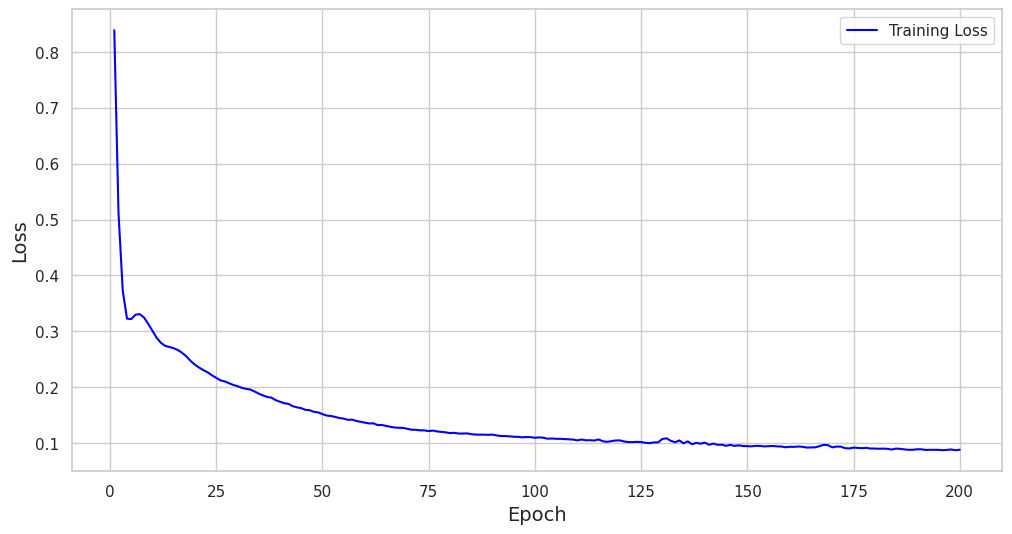

In [32]:
# 绘制损失变化图
plt.figure(figsize=(12, 6))
plt.plot(range(1, 201), loss_st, color='blue', label='Training Loss')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

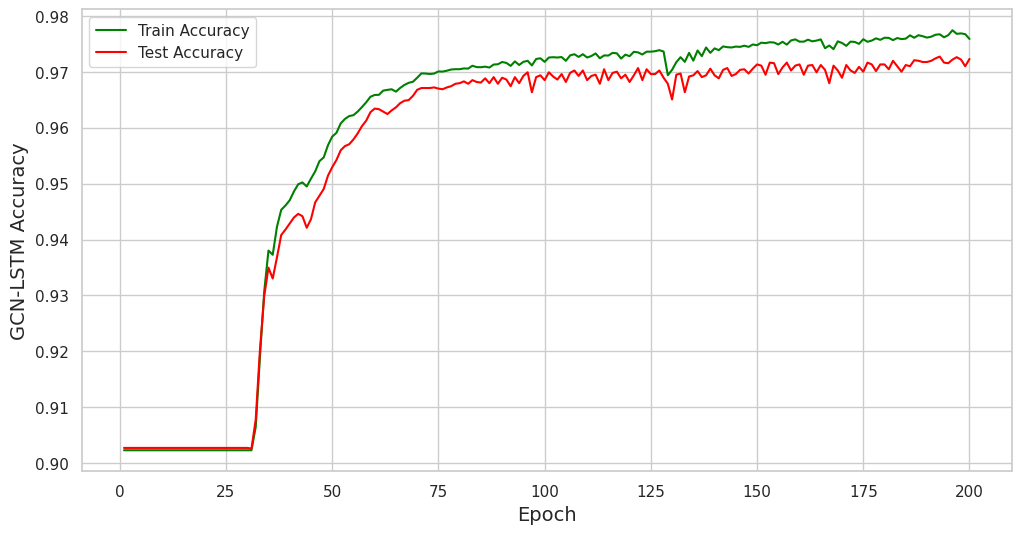

In [33]:
# 绘制训练和测试准确率变化图
plt.figure(figsize=(12, 6))
plt.plot(range(1, 201), accs_train, color='green', label='Train Accuracy')
plt.plot(range(1, 201), accs_test, color='red', label='Test Accuracy')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('GCN-LSTM Accuracy', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

### GCN-LSTM Model Eval

In [34]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import numpy as np

# 在测试集和训练集上评估模型
print("=== GCN-LSTM Model Eval ===")
model.eval()
with torch.no_grad():
    out = model(data)
    pred = out.argmax(dim=1)
    
    # 训练集评估
    y_train = data.y[data.train_mask].cpu().numpy()
    y_pred_train = pred[data.train_mask].cpu().numpy()
    
    acc_train = accuracy_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train, average='macro')
    f1_train = f1_score(y_train, y_pred_train, average='macro')
    
    print(f"Train Accuracy: {acc_train:.4f}")
    print(f"Train Recall: {recall_train:.4f}")
    print(f"Train F1 Score: {f1_train:.4f}")
    
    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_accuracy_train = cm_train.astype('float') / cm_train.sum(axis=1)[:, np.newaxis]
    
    # 测试集评估
    y_test = data.y[data.test_mask].cpu().numpy()
    y_pred_test = pred[data.test_mask].cpu().numpy()
    
    acc = accuracy_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test, average='macro')
    f1 = f1_score(y_test, y_pred_test, average='macro')
    
    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    
    cm = confusion_matrix(y_test, y_pred_test)
    cm_accuracy = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

=== GCN-LSTM Model Eval ===
Train Accuracy: 0.9759
Train Recall: 0.8872
Train F1 Score: 0.9249
Test Accuracy: 0.9723
Test Recall: 0.8800
Test F1 Score: 0.9140


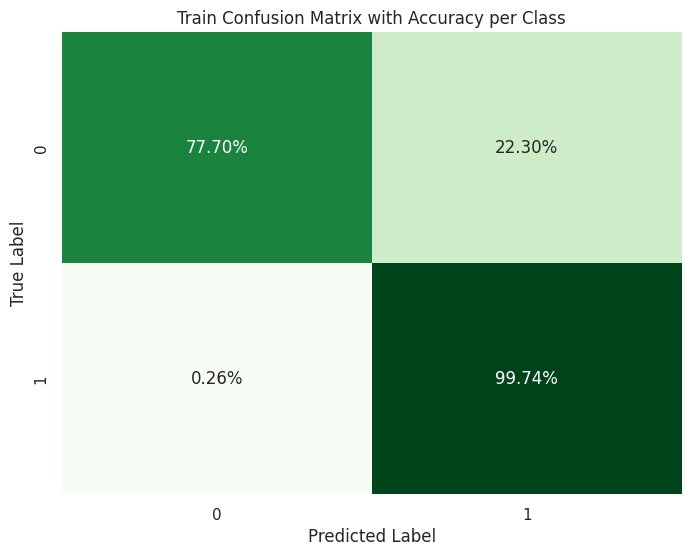

In [35]:
# 绘制训练集混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm_accuracy_train, annot=True, fmt='.2%', cmap='Greens', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Train Confusion Matrix with Accuracy per Class')
plt.show()

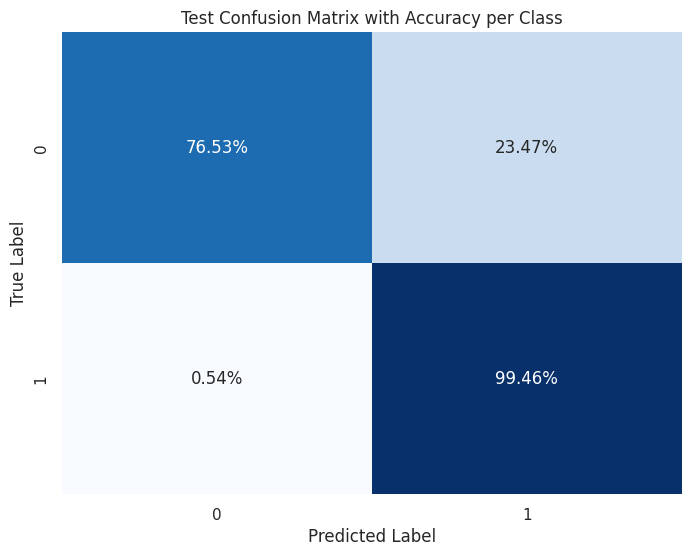

In [36]:
# 绘制测试集混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm_accuracy, annot=True, fmt='.2%', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Test Confusion Matrix with Accuracy per Class')
plt.show()

## 5. GCN-LSTM-Attention

In [37]:
from torch_geometric.nn import GATConv

# 定义图注意力层
class GATLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GATLayer, self).__init__()
        self.gat_conv = GATConv(in_channels, out_channels, heads=1, concat=False)

    def forward(self, x, edge_index):
        x = self.gat_conv(x, edge_index)
        return F.relu(x)

# GCN-LSTM-GAT模型
class GCN_LSTM_GAT(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes, lstm_hidden_size, lstm_num_layers):
        super(GCN_LSTM_GAT, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.gat_layer = GATLayer(hidden_channels, hidden_channels)
        self.lstm = LSTM(hidden_channels, lstm_hidden_size, lstm_num_layers, batch_first=True)
        self.fc = torch.nn.Linear(lstm_hidden_size, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # GCN部分
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        # GAT部分
        x = self.gat_layer(x, edge_index)
        x = F.dropout(x, training=self.training)

        # LSTM部分
        x = x.unsqueeze(0)
        x, _ = self.lstm(x)
        x = x.squeeze(0)

        # 全连接层输出分类结果
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [38]:
# 初始化模型
model = GCN_LSTM_GAT(num_node_features=x.shape[1], hidden_channels=64, num_classes=2, lstm_hidden_size=32, lstm_num_layers=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model

GCN_LSTM_GAT(
  (conv1): GCNConv(166, 64)
  (gat_layer): GATLayer(
    (gat_conv): GATConv(64, 64, heads=1)
  )
  (lstm): LSTM(64, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)

In [39]:
## 模型训练
loss_st = list()
accs_train = list()
accs_test = list()
for epoch in range(1, 201):
    ## 训练模型
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    loss_st.append(loss.detach().numpy())
    
    ## 模型验证
    ### 训练集验证
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()
    acc_train = int(correct) / int(data.train_mask.sum())
    accs_train.append(acc_train)
    
    ### 测试集验证
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc_test = int(correct) / int(data.test_mask.sum())
    accs_test.append(acc_test)
    if epoch % 10 == 0:
        print(f"""====================== Epoch {epoch} ======================
Loss: {loss:.4f}, Train Accuracy: {acc_train:.4f}, Test Accuracy: {acc_test:.4f}""")

====================== Epoch 10 ======================
Loss: 0.3104, Train Accuracy: 0.9023, Test Accuracy: 0.9027
====================== Epoch 20 ======================
Loss: 0.2596, Train Accuracy: 0.9023, Test Accuracy: 0.9027
====================== Epoch 30 ======================
Loss: 0.2053, Train Accuracy: 0.9023, Test Accuracy: 0.9027
====================== Epoch 40 ======================
Loss: 0.1668, Train Accuracy: 0.9590, Test Accuracy: 0.9583
====================== Epoch 50 ======================
Loss: 0.1385, Train Accuracy: 0.9665, Test Accuracy: 0.9673
====================== Epoch 60 ======================
Loss: 0.1235, Train Accuracy: 0.9695, Test Accuracy: 0.9684
====================== Epoch 70 ======================
Loss: 0.1164, Train Accuracy: 0.9717, Test Accuracy: 0.9697
====================== Epoch 80 ======================
Loss: 0.1120, Train Accuracy: 0.9720, Test Accuracy: 0.9712
====================== Epoch 90 ======================
Loss: 0.1046, Train Accur

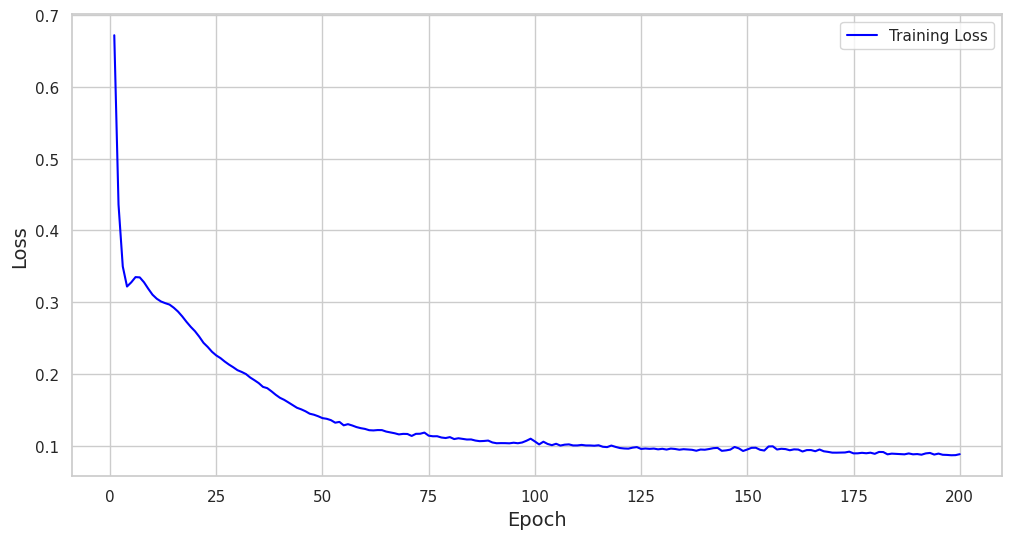

In [40]:
# 绘制损失变化图
plt.figure(figsize=(12, 6))
plt.plot(range(1, 201), loss_st, color='blue', label='Training Loss')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

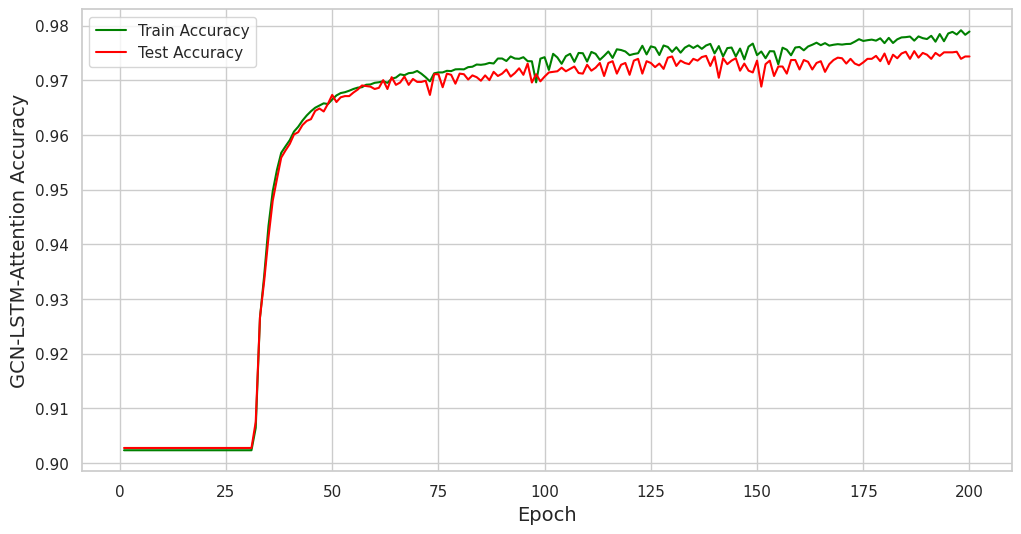

In [41]:
# 绘制训练和测试准确率变化图
plt.figure(figsize=(12, 6))
plt.plot(range(1, 201), accs_train, color='green', label='Train Accuracy')
plt.plot(range(1, 201), accs_test, color='red', label='Test Accuracy')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('GCN-LSTM-Attention Accuracy', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

### GCN-LSTM-Attention Model Eval

In [42]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import numpy as np

# 在测试集和训练集上评估模型
print("=== GCN-LSTM-Attention Model Eval ===")
model.eval()
with torch.no_grad():
    out = model(data)
    pred = out.argmax(dim=1)
    
    # 训练集评估
    y_train = data.y[data.train_mask].cpu().numpy()
    y_pred_train = pred[data.train_mask].cpu().numpy()
    
    acc_train = accuracy_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train, average='macro')
    f1_train = f1_score(y_train, y_pred_train, average='macro')
    
    print(f"Train Accuracy: {acc_train:.4f}")
    print(f"Train Recall: {recall_train:.4f}")
    print(f"Train F1 Score: {f1_train:.4f}")
    
    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_accuracy_train = cm_train.astype('float') / cm_train.sum(axis=1)[:, np.newaxis]
    
    # 测试集评估
    y_test = data.y[data.test_mask].cpu().numpy()
    y_pred_test = pred[data.test_mask].cpu().numpy()
    
    acc = accuracy_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test, average='macro')
    f1 = f1_score(y_test, y_pred_test, average='macro')
    
    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    
    cm = confusion_matrix(y_test, y_pred_test)
    cm_accuracy = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

=== GCN-LSTM-Attention Model Eval ===
Train Accuracy: 0.9789
Train Recall: 0.9081
Train F1 Score: 0.9361
Test Accuracy: 0.9744
Test Recall: 0.8965
Test F1 Score: 0.9222


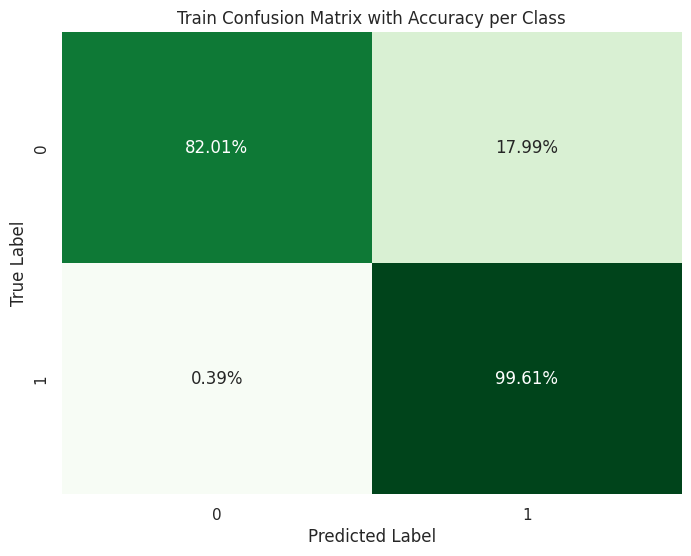

In [43]:
# 绘制训练集混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm_accuracy_train, annot=True, fmt='.2%', cmap='Greens', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Train Confusion Matrix with Accuracy per Class')
plt.show()

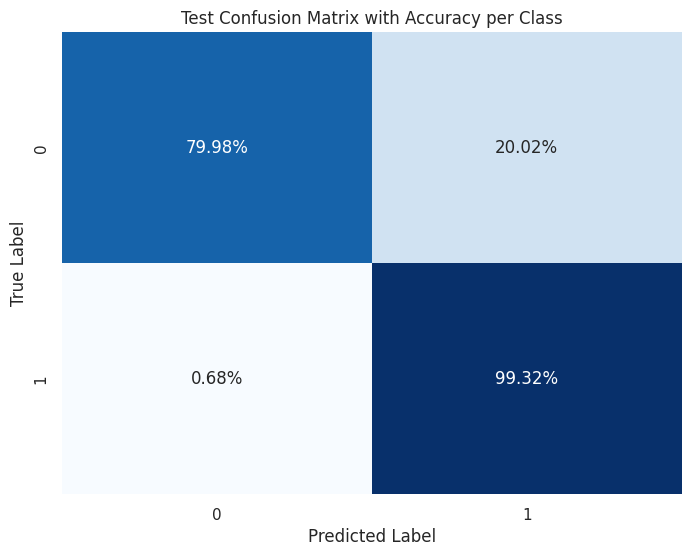

In [44]:
# 绘制测试集混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm_accuracy, annot=True, fmt='.2%', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Test Confusion Matrix with Accuracy per Class')
plt.show()